## Run the inference with the PyTorch model

In [1]:
import torch
import lightglue_dynamo.models.superpoint_pytorch as superpoint_pytorch

detection_thresh = 0.005
nms_radius = 5
max_keypoints = 256

sp_th = superpoint_pytorch.SuperPointOpen(detection_threshold=detection_thresh, nms_radius=nms_radius, max_num_keypoints=max_keypoints).eval()
print('Config:', sp_th.conf)

# Load state dict (map_location="cpu" if no GPU)
ckpt = torch.load("/home/nvidia/third_party/LightGlue-ONNX-Jetson/weights/superpoint_v6_from_tf.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")

# Some checkpoints may be wrapped in {"state_dict": ...}
if "state_dict" in ckpt:
    ckpt = ckpt["state_dict"]

# Load weights
sp_th.load_state_dict(ckpt, strict=True)
sp_th.eval().cuda()
# sp_th = torch.compile(sp_th, mode="reduce-overhead")  # "max-autotune" , "reduce-overhead"

/home/nvidia/third_party/LightGlue-ONNX-Jetson/.venv/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/nvidia/third_party/LightGlue-ONNX-Jetson/.venv/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Config: namespace(nms_radius=5, max_num_keypoints=256, detection_threshold=0.005, remove_borders=4, descriptor_dim=256, channels=[64, 64, 128, 128, 256])


/tmp/ipykernel_61773/1623159141.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/home/nvidia/third_party/LightGlue-ONNX-Jetson/weights/superpoint_v6_

SuperPointOpen(
  (backbone): Sequential(
    (0): Sequential(
      (0): VGGBlock(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): VGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): VGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): VGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [2]:
import torch
import cv2
import numpy as np
from lightglue_dynamo.preprocessors import SuperPointOpenPreprocessor
from lightglue_dynamo import viz

# --- 1. Load and Normalize Images Individually ---
image_path1 = '/home/nvidia/third_party/LightGlue-ONNX-Jetson/assets/debug1.png'
image_path2 = '/home/nvidia/third_party/LightGlue-ONNX-Jetson/assets/debug2.png'

h, w = 400, 640 

# Load color images and resize them
raw_img1 = cv2.resize(cv2.imread(image_path1), (w, h))
raw_img2 = cv2.resize(cv2.imread(image_path2), (w, h))
image_batch_bgr = np.stack([raw_img1, raw_img2], axis=0)
preprocessed_batch = SuperPointOpenPreprocessor.preprocess(image_batch_bgr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor = torch.from_numpy(preprocessed_batch).to(device)

print(f"Final tensor shape: {tensor.shape}") #torch.Size([2, 1, H_padded, W_padded])

Final tensor shape: torch.Size([2, 1, 400, 640])


Keypoints: (2, 256, 2)
Keypoint scores: (2, 256)
Descriptors: (2, 256, 256)
Number of keypoints: (2,)


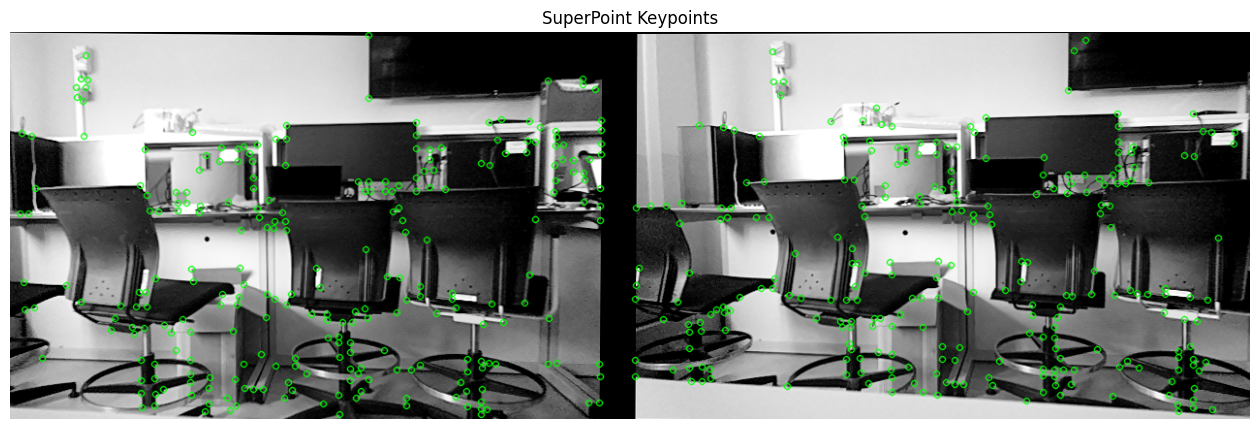

In [3]:
with torch.no_grad():
    pred = sp_th({"image": tensor})

kpts = pred['keypoints'].cpu().numpy()
scores = pred['keypoint_scores'].cpu().numpy()
descriptors = pred['descriptors'].cpu().numpy()
num_kpts = pred['num_keypoints'].cpu().numpy()

print(f"Keypoints: {kpts.shape}")
print(f"Keypoint scores: {scores.shape}")
print(f"Descriptors: {descriptors.shape}")
print(f"Number of keypoints: {num_kpts.shape}")

viz.plot_sp_open(image_batch_bgr, image_batch_bgr.shape[0], kpts, num_kpts)

Input Name: images
Output Names: ['keypoints', 'keypoint_scores', 'descriptors', 'num_keypoints']
Preprocessed batch: (2, 1, 400, 640) float32 0.0 1.0

--- ONNX Runtime Output ---
Keypoints shape: (2, 256, 2)
Scores shape: (2, 256)
Descriptors shape: (2, 256, 256)
Num Keypoints: [256 256]
Num keypoints (ONNX): [256 256]
Num keypoints (sum): 512


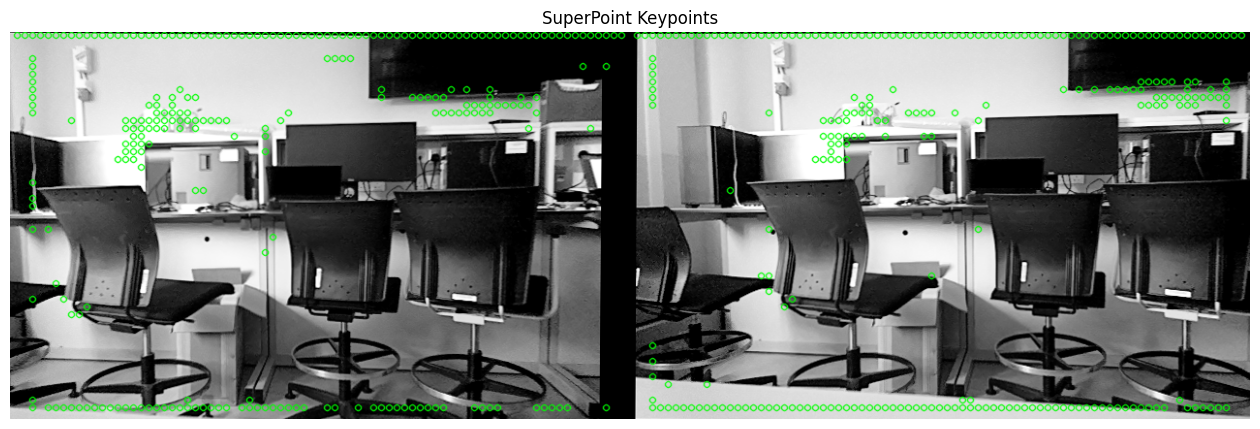

In [ ]:
import onnxruntime as ort

onnx_model_path = '/home/nvidia/third_party/LightGlue-ONNX-Jetson/weights/superpoint_open_b2_h400_w640_kp256.onnx'
session = ort.InferenceSession(onnx_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

input_name = session.get_inputs()[0].name
output_names = [output.name for output in session.get_outputs()]
print(f"Input Name: {input_name}")
print(f"Output Names: {output_names}")

# Run Inference
onnx_inputs = {input_name: preprocessed_batch}
print("Preprocessed batch:", preprocessed_batch.shape, preprocessed_batch.dtype,
      preprocessed_batch.min(), preprocessed_batch.max())

outputs_onnx = session.run(output_names, onnx_inputs)

# Unpack the list of outputs
kpts_onnx, scores_onnx, desc_onnx, num_kpts_onnx = outputs_onnx

print("\n--- ONNX Runtime Output ---")
print(f"Keypoints shape: {kpts_onnx.shape}")
print(f"Scores shape: {scores_onnx.shape}")
print(f"Descriptors shape: {desc_onnx.shape}")
print(f"Num Keypoints: {num_kpts_onnx}")
print("Num keypoints (ONNX):", num_kpts_onnx)
print("Num keypoints (sum):", sum(num_kpts_onnx) if num_kpts_onnx.ndim > 0 else num_kpts_onnx)

viz.plot_sp_open(image_batch_bgr, image_batch_bgr.shape[0], kpts_onnx, num_kpts_onnx)